In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn
from IPython.display import display
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.regularizers import l2, activity_l2

/home/calvinjku/anaconda3/envs/keras/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/calvinjku/anaconda3/envs/keras/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
def load_images_from_folder(X_train_names):
    images = []
    for filename in X_train_names:
        img = plt.imread(filename)
        if img is not None:
            images.append(img)
    return images

def load_data_from_folder(folder_name):
    driving_log = pd.DataFrame.from_csv('./' + folder_name + '/driving_log.csv', index_col=None)
    driving_log.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']
    
    X_train_center = ["./" + folder_name + "/" + x for x in driving_log['Center Image'].values.tolist()]
    X_train_center = np.asarray(load_images_from_folder(X_train_center))

    X_train_left = ["./" + folder_name + "/" + x[1:] for x in driving_log['Left Image'].values.tolist()]
    X_train_left = np.asarray(load_images_from_folder(X_train_left))

    X_train_right = ["./" + folder_name + "/" + x[1:] for x in driving_log['Right Image'].values.tolist()]
    X_train_right = np.asarray(load_images_from_folder(X_train_right))

    X_train = np.concatenate((X_train_center, X_train_left, X_train_right), axis=0)

    y_train = driving_log['Steering Angle'].values.tolist()

    y_train_center = y_train
    y_train_left = [x + 0.2 for x in y_train]
    y_train_right = [x - 0.2 for x in y_train]
    
    y_train = np.asarray(y_train_center + y_train_left + y_train_right)
    
    return X_train, y_train

In [ ]:
X_train_my, y_train_my = load_data_from_folder('my_data')
X_train_udacity, y_train_udacity = load_data_from_folder('udacity_data')

In [4]:
max_label = y_train_my.max()
min_label = y_train_my.min()

step_size = (max_label - min_label) / 20.

data_in_bins = [[] for x in range(20)]

for i, value in enumerate(y_train_my):
    index = floor((((value - min_label) * 20) / (max_label - min_label) - 2))
    data_in_bins[index].append(i)

# Select indices from data_in_bin
balance_index = []

for b in data_in_bins:
    i = 0
    b_len = len(b)
    
    while i < b_len and i < 2000:
        balance_index.append(b[i])
        i += 1

In [5]:
X_train_balance, y_train_balance = X_train_my[balance_index], y_train_my[balance_index]

In [6]:
def crop_single_image(image):
    return image[70:][:][:-20][:]

def crop_sky_and_front_cover(image_data):
    return np.apply_along_axis(crop_single_image, axis=1, arr=image_data)

def normalize_single_image(image):
    return (image - np.mean(image)) / (np.max(image) - np.min(image))

def rgb_2_hsv_single_image(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def preprocess(image_data):
    if len(image_data.shape) == 4:
        # Crop data
        cropped = crop_sky_and_front_cover(image_data)
        
        # Resize data
        image_data_small = []
        for image in cropped:
            image_data_small.append(cv2.resize(image, (0,0), fx=0.5, fy=0.5))
        
        # HSV data
        image_data_hsv = []
        for image in image_data_small:
            image_data_hsv.append(rgb_2_hsv_single_image(image))
        
        # Normalize data
        image_data_normalized = []
        for image in image_data_hsv:
            image_data_normalized.append(normalize_single_image(image))
        
        image_data_normalized = np.asarray(image_data_normalized)
    
    elif len(image_data.shape) == 3:
        # Crop data
        cropped =  crop_single_image(image_data)
        
        # Resize data
        small = cv2.resize(cropped, (0,0), fx=0.5, fy=0.5)
            
        # HSV data
        image_data_hsv = rgb_2_hsv_single_image(small)
        
        # Normalize data
        image_data_normalized = normalize_single_image(image_data_hsv)
                                                 
    else:
        raise TypeError("Wrong image shape!")
    

    return image_data_normalized

In [7]:
import random

def batch_generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 35, 160, 3))
    batch_labels = np.zeros((batch_size,),)
    
    while 1:
        for i in range(batch_size):
            #choose random index in features
            index = random.randint(0, len(features) - 1)
            
            batch_features[i] = preprocess(features[index])
            # For when image is gray and not having the redundant dim
#             batch_features[i] = np.expand_dims(preprocess(features[index]), axis=2)
            batch_labels[i] = labels[index]
            
        yield batch_features, batch_labels

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.regularizers import l2, activity_l2

def yadav_model(image_dim, conv_drop=0.2, fc_drop=0.5):
    # image dim
    row, col, channel = image_dim

    model = Sequential()
    
    model.add(Convolution2D(3, 1, 1, input_shape=image_dim))
    
    model.add(Convolution2D(32, 3, 3))
    model.add(Convolution2D(32, 3, 3))
    model.add(MaxPooling2D((2, 2), border_mode='same'))
    model.add(Dropout(conv_drop))
    model.add(ELU())

    model.add(Convolution2D(64, 3, 3))
    model.add(Convolution2D(64, 3, 3))
    model.add(MaxPooling2D((2, 2), border_mode='same'))
    model.add(Dropout(conv_drop))
    model.add(ELU())

    model.add(Convolution2D(128, 3, 3))
    model.add(Convolution2D(128, 3, 3))
    model.add(MaxPooling2D((2, 2), border_mode='same'))
    model.add(Dropout(conv_drop))
    model.add(ELU())

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Dropout(fc_drop))
    model.add(ELU())

    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(ELU())

    model.add(Dense(16))
    model.add(Dropout(0.5))
    model.add(LeakyReLU())

    model.add(Dense(1))
    
    return model

Using TensorFlow backend.


In [9]:
# import json
# from keras.models import model_from_json

# # load json and create model
# json_file = open('model_report.json', 'r')
# loaded_model_json = json.loads(json_file.read())
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("model_report.h5")
# print("Loaded model from disk")

In [16]:
model = yadav_model((35, 160, 3), conv_drop=0.6, fc_drop=0.75)

In [17]:
from keras.optimizers import Adam

# initialize generators
training_samples_gen = batch_generator(X_train_balance, y_train_balance, batch_size=100)
validation_samples_gen = batch_generator(X_train_udacity, y_train_udacity, batch_size=100)

adam = Adam(lr=0.001)
model.compile(loss='mse', optimizer=adam)
history = model.fit_generator(training_samples_gen, samples_per_epoch=20000, nb_epoch=11, verbose=1, validation_data=validation_samples_gen, nb_val_samples=24000)

Epoch 1/11
20000/20000 [==============================] - 31s - loss: 0.1243 - val_loss: 0.0386
Epoch 2/11
20000/20000 [==============================] - 30s - loss: 0.0425 - val_loss: 0.0346
Epoch 3/11
20000/20000 [==============================] - 30s - loss: 0.0343 - val_loss: 0.0401
Epoch 4/11
20000/20000 [==============================] - 30s - loss: 0.0299 - val_loss: 0.0419
Epoch 5/11
20000/20000 [==============================] - 30s - loss: 0.0278 - val_loss: 0.0339
Epoch 6/11
20000/20000 [==============================] - 31s - loss: 0.0256 - val_loss: 0.0264
Epoch 7/11
20000/20000 [==============================] - 30s - loss: 0.0243 - val_loss: 0.0341
Epoch 8/11
20000/20000 [==============================] - 31s - loss: 0.0238 - val_loss: 0.0292
Epoch 9/11
20000/20000 [==============================] - 30s - loss: 0.0229 - val_loss: 0.0288
Epoch 10/11
20000/20000 [==============================] - 30s - loss: 0.0209 - val_loss: 0.0234
Epoch 11/11
20000/20000 [==============

dict_keys(['val_loss', 'loss'])


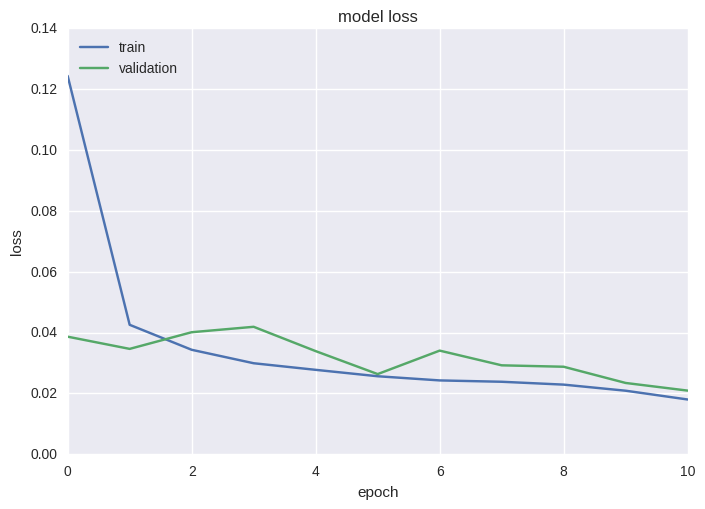

In [18]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
# # TODO: Evaluate model on test data
# metrics = model.evaluate(X_normalized_test, y_one_hot_test)
# for metric_i in range(len(model.metrics_names)):
#     metric_name = model.metrics_names[metric_i]
#     metric_value = metrics[metric_i]
#     print('{}: {}'.format(metric_name, metric_value))

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_8 (Convolution2D)  (None, 35, 160, 3)    12          convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 33, 158, 32)   896         convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 31, 156, 32)   9248        convolution2d_9[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 16, 78, 32)    0           convolution2d_10[0][0]           
___________________________________________________________________________________________

In [21]:
import json
with open('model_report.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

model.save_weights('model_report.h5')